# Serving TTS

This notebook aims to achieve the following things:

1. Select the model that best achieves our goals
2. Expose a websocket endpoint to the model
3. Exceed expectations for latency and character alignment accuracy
4. Have the voice agent speak in human english when given mathematical notation
5. Walk through my end to end *process* of achieving the above goals

6. Self selected bonus point: Many of SigIQ's clients are from outside the US; using a TTS model that can speak another language may be useful

# Setup:

In [1]:
import os, time, json, csv
from pathlib import Path
import numpy as np
import soundfile as sf
import subprocess
import sys
import time
import numpy as np
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Dict
import librosa

# output directories
runs_dir = Path("runs_kokoro").resolve()
runs_dir.mkdir(exist_ok=True)
audio_dir = runs_dir / "audio"
audio_dir.mkdir(exist_ok=True)
os.environ["TTS_DENOISE"]="1"

def _ensure(package, import_name=None, extra_pip=None):
    try:
        __import__(import_name or package)
    except Exception:
        cmd = [sys.executable, "-m", "pip", "install", package] + (extra_pip or [])
        print("[pip] Installing", package, " ".join(extra_pip or []))
        subprocess.check_call(cmd)
    return __import__(import_name or package)

sf = _ensure("soundfile")
librosa = _ensure("librosa")
hf_hub = _ensure("huggingface_hub", "huggingface_hub")

@dataclass
class BenchResult:
    model: str
    language: str
    text_len: int
    ttfb_ms: float
    rtf: float
    wav_path: str
    synth_ms: Optional[float] = None
    audio_ms: Optional[float] = None
    wer: Optional[float] = None
    cer: Optional[float] = None
    notes: Optional[str] = ""

def hf_download(repo_id: str, revision: Optional[str] = None, local_dir: Optional[Path] = None) -> Path:
    # Import dynamically to avoid circular dependency
    hf_hub = _ensure("huggingface_hub", "huggingface_hub")
    from huggingface_hub import snapshot_download
    local_dir = local_dir or Path("./models") / repo_id.replace("/", "__")
    local_dir.parent.mkdir(parents=True, exist_ok=True)
    snapshot_download(repo_id=repo_id, revision=revision, local_dir=str(local_dir), local_dir_use_symlinks=False)
    return local_dir

def resample_if_needed(y, orig_sr: int, target_sr: int = 44100):
    if orig_sr == target_sr:
        return y
    return librosa.resample(y, orig_sr=orig_sr, target_sr=target_sr)

class Synthesizer:
    """Base class for TTS synthesizers used in this benchmark."""
    def __init__(self, device: str = "cuda"):
        self.device = device

    def download(self):
        """Download / prepare model weights."""
        pass

    def synthesize(self, text: str, language: str = "en"):
        """
        Returns: (waveform_float32[-1..1], sample_rate, meta_dict)
        meta_dict may include timings, tokens, etc.
        """
        raise NotImplementedError

In [2]:
class KokoroSynth(Synthesizer):
    def __init__(self, device="cuda", lang_code="a", voice="af_heart"):
        super().__init__(device)
        self.lang_code = lang_code  # 'a' for American English
        self.voice = voice
        self.pipeline = None
        self.ready = False

    def download(self):
        """Initialize Kokoro TTS (assumes packages are preinstalled)."""
        try:
            print("[Kokoro] Checking runtime deps (numpy, torch, transformers, kokoro)...")
            import numpy  # noqa: F401
            import torch  # noqa: F401
            import transformers  # noqa: F401
            from kokoro import KPipeline
            print("[Kokoro] Initializing pipeline...")
            self.pipeline = KPipeline(lang_code=self.lang_code)
            self.ready = True
            print(f"[Kokoro] Pipeline ready with lang_code='{self.lang_code}', voice='{self.voice}'")
        except Exception as e:
            print(f"[WARN] Kokoro initialization failed: {e}")
            print("[INFO] Note: kokoro may require additional system dependencies (espeak-ng)")
            self.ready = False

    def synthesize(self, text: str, language="en"):
        """Generate speech using Kokoro TTS and return per-character alignment from native durations."""
        if not self.ready or self.pipeline is None:
            self.download()
        if not self.ready or self.pipeline is None:
            raise RuntimeError(
                "Kokoro pipeline not initialized. Check torch/transformers compatibility and system deps (espeak-ng)."
            )
        
        start_time = time.perf_counter()
        
        # Generate using Kokoro pipeline
        generator = self.pipeline(
            text, 
            voice=self.voice,
            speed=1.0, 
            split_pattern=r'\n+'
        )
        
        # Collect all audio segments and build char-level alignment from tokens
        audio_segments = []
        seg_sr = 24000  # Kokoro's native sample rate
        offset_s = 0.0
        all_chars = []
        all_start_s = []
        all_dur_s = []

        for i, result in enumerate(generator):
            # result is KPipeline.Result (back-compat iteration returns (gs, ps, audio))
            audio_t = getattr(result, 'audio', None)
            if audio_t is None:
                # Backward-compat tuple iteration
                try:
                    _, _, audio_t = result
                except Exception:
                    continue
            # Convert to float32 numpy on CPU
            try:
                audio_np = audio_t.detach().float().cpu().numpy()
            except Exception:
                audio_np = np.asarray(audio_t, dtype=np.float32)
            audio_segments.append(audio_np)

            # Build alignment from tokens if available
            tks = getattr(result, 'tokens', None)
            if tks:
                for t in tks:
                    token_text = (getattr(t, 'text', '') or '')
                    ws = getattr(t, 'whitespace', '')
                    if isinstance(ws, str):
                        token_text += ws
                    elif ws:
                        token_text += ' '
                    ts = getattr(t, 'start_ts', None)
                    te = getattr(t, 'end_ts', None)
                    if ts is None or te is None:
                        continue
                    te = float(te)
                    ts = float(ts)
                    if te <= ts:
                        continue
                    if len(token_text) == 0:
                        continue
                    token_start = offset_s + ts
                    token_dur = te - ts
                    n_chars = len(token_text)
                    per_char = token_dur / float(max(1, n_chars))
                    for j, ch in enumerate(token_text):
                        all_chars.append(ch)
                        all_start_s.append(token_start + j * per_char)
                        all_dur_s.append(per_char)

            # Advance segment offset in seconds (using native 24kHz length)
            offset_s += float(audio_np.shape[0]) / float(seg_sr)

            if i >= 10:  # Limit to prevent excessive generation
                break
        
        if not audio_segments:
            raise ValueError("No audio generated")
        
        # Concatenate segments (24 kHz)
        waveform_24k = np.concatenate(audio_segments).astype(np.float32, copy=False)
        elapsed = time.perf_counter() - start_time
        
        # Resample to standard 44.1kHz
        waveform = resample_if_needed(waveform_24k, seg_sr, 44100)
        sr_out = 44100

        # Convert alignment to integer milliseconds while preserving total duration
        char_alignment = None
        if all_chars:
            total_ms = int(round(len(waveform) * 1000.0 / float(sr_out)))
            raw_ms = [d * 1000.0 for d in all_dur_s]
            floored = [int(ms) for ms in raw_ms]
            remainder = total_ms - sum(floored)
            fracs = [(ms - int(ms), idx) for idx, ms in enumerate(raw_ms)]
            fracs.sort(reverse=True)
            durations_ms = floored[:]
            k = 0
            while remainder > 0 and k < len(fracs):
                durations_ms[fracs[k][1]] += 1
                remainder -= 1
                k += 1
            starts_ms = []
            acc = 0
            for d in durations_ms:
                starts_ms.append(acc)
                acc += d
            char_alignment = {
                "chars": all_chars,
                "char_start_times_ms": starts_ms,
                "char_durations_ms": durations_ms,
            }
        
        meta = {
            "elapsed_synth_s": elapsed,
            "original_sr": seg_sr,
            "segments": len(audio_segments),
            "voice": self.voice,
            "lang_code": self.lang_code,
        }
        if char_alignment is not None:
            meta["char_alignment"] = char_alignment
        
        return waveform.astype(np.float32), sr_out, meta


## Kokoro run sanity check

In [3]:
synth = KokoroSynth(device="cuda")
synth.download()


[Kokoro] Checking runtime deps (numpy, torch, transformers, kokoro)...


/mnt/ayan-disk2/Overlap/TestingGPU/work/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/ayan-disk2/Overlap/TestingGPU/work/env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/ayan-disk2/Overlap/TestingGPU/work/env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


[Kokoro] Initializing pipeline...


/mnt/ayan-disk2/Overlap/TestingGPU/work/env/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/mnt/ayan-disk2/Overlap/TestingGPU/work/env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[Kokoro] Pipeline ready with lang_code='a', voice='af_heart'


In [4]:
# sample texts (English only)
texts = [
    "This is a simple test of Kokoro TTS.",
    "Artificial Intelligence is transforming education across the world.",
    "How fast can Kokoro generate this audio file?"
]

def run_benchmark(synthesizer: Synthesizer, model_name: str, texts: list, runs_dir: Path) -> list:
    """
    Run benchmark tests on a TTS synthesizer.
    
    Args:
        synthesizer: Instance of a Synthesizer class
        model_name: Name of the model for identification (e.g., "kokoro-82M")
        texts: List of text strings to synthesize
        runs_dir: Directory to save audio files and CSV results
        
    Returns:
        List of BenchResult objects containing timing and quality metrics
    """
    # Create audio directory for this model
    audio_dir = runs_dir / "audio"
    audio_dir.mkdir(exist_ok=True)
    
    results = []
    
    print(f"[{model_name}] Starting benchmark with {len(texts)} texts...")
    
    for idx, text in enumerate(texts):
        t0 = time.perf_counter()
        audio, sr, meta = synthesizer.synthesize(text)
        elapsed = time.perf_counter() - t0
        
        # Save audio file
        wav_path = audio_dir / f"{model_name.lower().replace('-', '_')}_{idx}.wav"
        sf.write(str(wav_path), audio, sr)
        
        # Calculate metrics
        audio_ms = len(audio) / sr * 1000.0
        rtf = elapsed / (len(audio) / sr)
        
        result = BenchResult(
            model=model_name,
            language="en",
            text_len=len(text),
            ttfb_ms=elapsed * 1000.0,
            rtf=rtf,
            wav_path=str(wav_path),
            synth_ms=elapsed * 1000.0,
            audio_ms=audio_ms
        )
        results.append(result)
        
        print(f"[{model_name}] Generated sample {idx+1}/{len(texts)} - RTF: {rtf:.3f}, Audio: {audio_ms:.1f}ms")
    
    # Save results to CSV
    csv_path = runs_dir / f"summary_{model_name.lower().replace('-', '_')}.csv"
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["model", "language", "text_len", "ttfb_ms", "rtf", "wav_path", "synth_ms", "audio_ms"])
        for r in results:
            writer.writerow([r.model, r.language, r.text_len, r.ttfb_ms, r.rtf, r.wav_path, r.synth_ms, r.audio_ms])
    
    print(f"[{model_name}] Benchmark complete! Generated {len(results)} samples")
    print(f"[{model_name}] Results saved to {csv_path}")
    
    return results


# Run benchmark using the abstracted function
results = run_benchmark(synth, "kokoro-82M", texts, runs_dir)

[kokoro-82M] Starting benchmark with 3 texts...


/mnt/ayan-disk2/Overlap/TestingGPU/work/env/lib/python3.11/site-packages/librosa/core/intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


[kokoro-82M] Generated sample 1/3 - RTF: 0.816, Audio: 3275.0ms
[kokoro-82M] Generated sample 2/3 - RTF: 0.029, Audio: 4775.0ms
[kokoro-82M] Generated sample 3/3 - RTF: 0.039, Audio: 3400.0ms
[kokoro-82M] Benchmark complete! Generated 3 samples
[kokoro-82M] Results saved to /mnt/ayan-disk2/Overlap/TestingGPU/work/runs_kokoro/summary_kokoro_82m.csv


# Serving

Here, we opt for a Receiver -> Chunker -> Synthesizer -> Output architecture as shown in the diagram

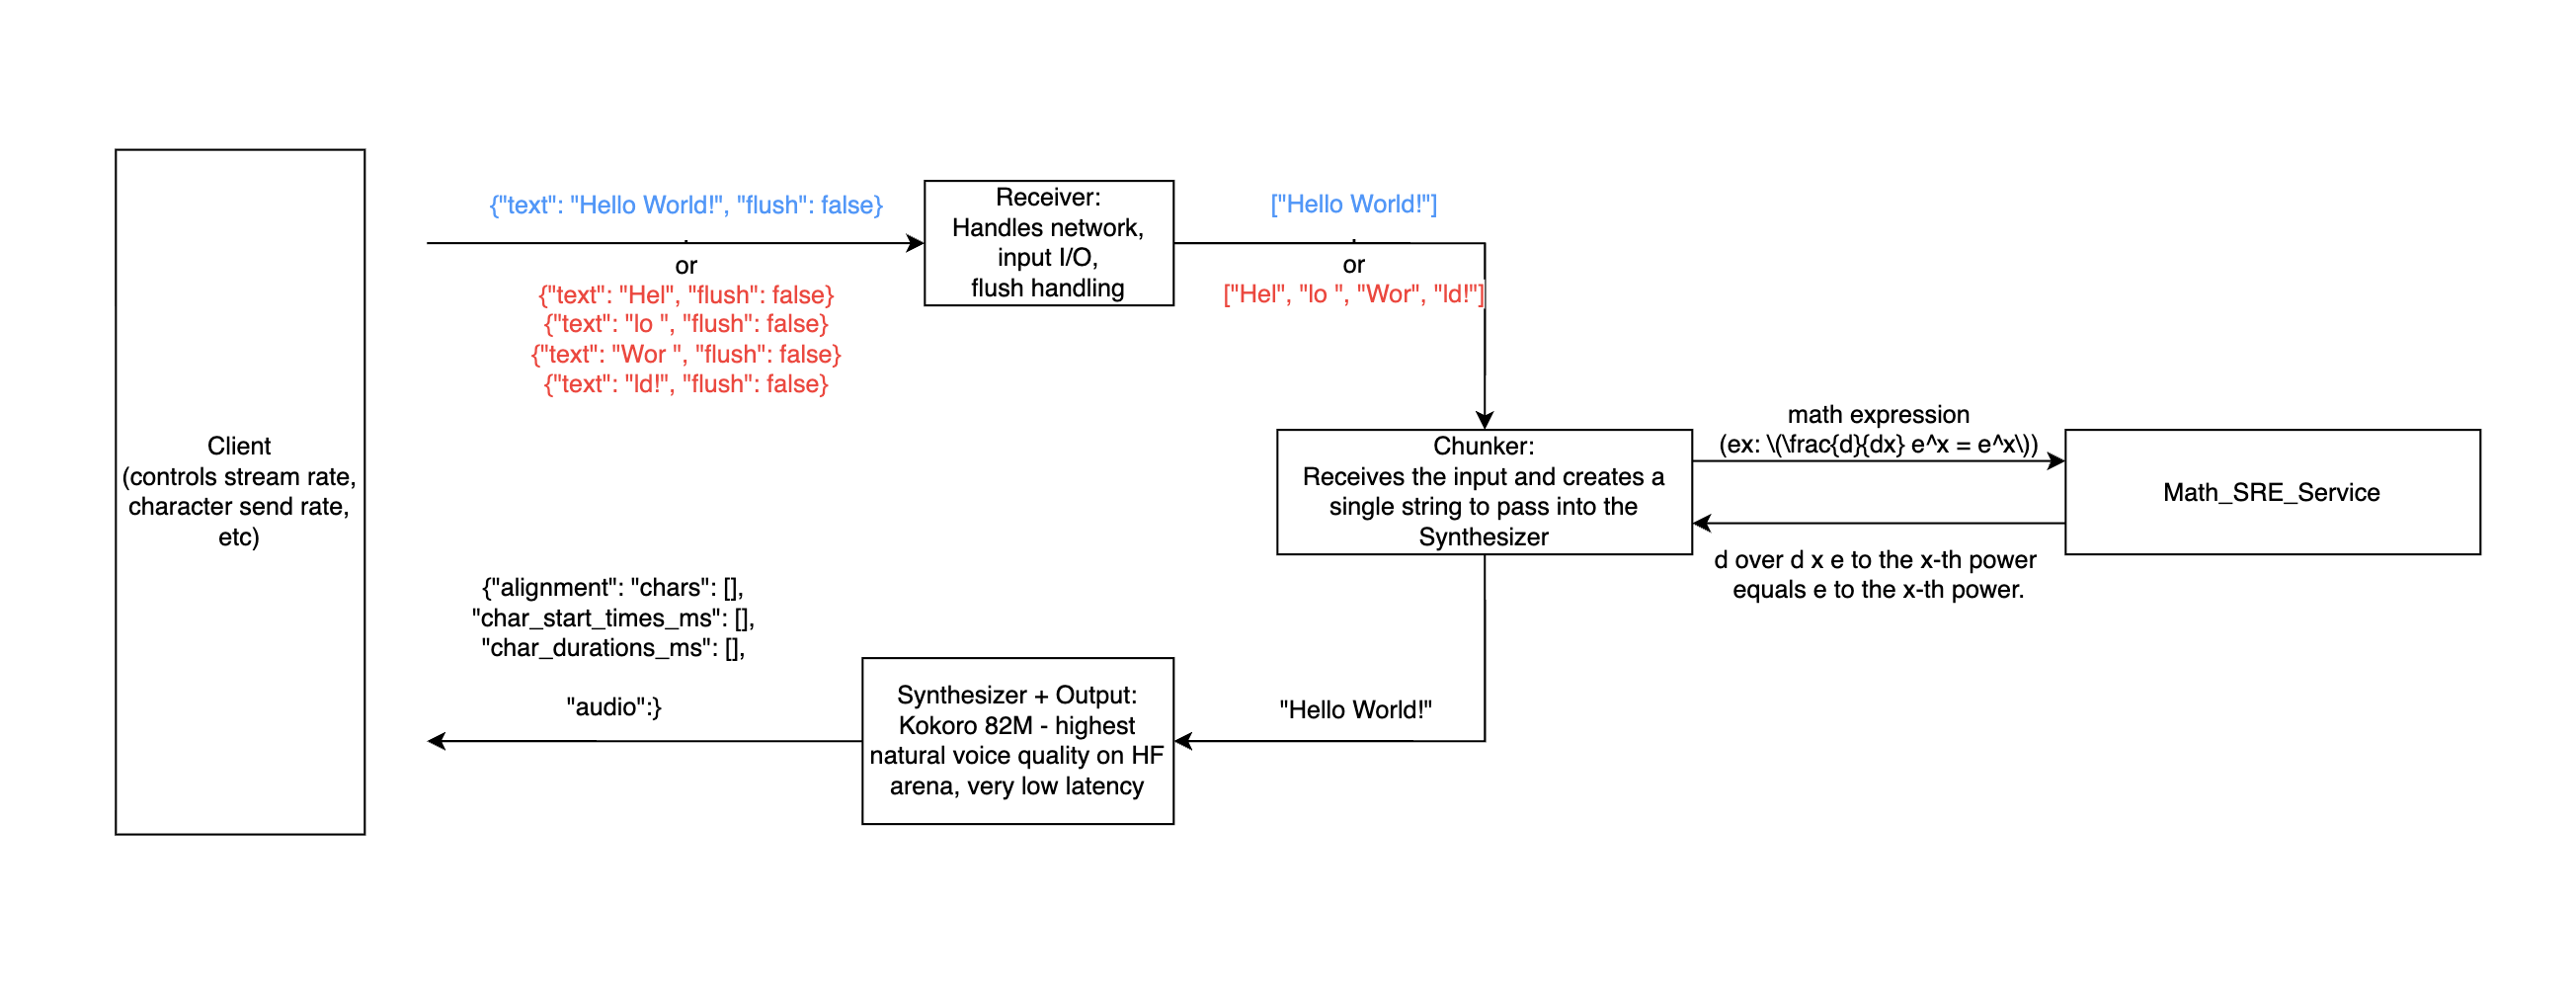

In [5]:
# Display the diagram image
from IPython.display import Image, display
display(Image("image.png"))


## Receiver

In [6]:
# Receiver: bidirectional WebSocket input side and shared buffer state

import asyncio
import json
from dataclasses import dataclass, field
from typing import Optional

websockets = _ensure("websockets>=12.0", "websockets")
from websockets.exceptions import ConnectionClosedOK, ConnectionClosedError


@dataclass
class IncomingTextBuffer:
    """
    Async-safe text buffer for accumulating client input.
    Other service loops (chunker/synth/sender) will read from this buffer.
    """
    _parts: list[str] = field(default_factory=list)
    _cursor: int = 0
    _lock: asyncio.Lock = field(default_factory=asyncio.Lock)
    new_text_event: asyncio.Event = field(default_factory=asyncio.Event)
    flush_event: asyncio.Event = field(default_factory=asyncio.Event)
    closed_event: asyncio.Event = field(default_factory=asyncio.Event)

    async def append(self, text: str) -> None:
        if not text:
            return
        async with self._lock:
            self._parts.append(text)
            self.new_text_event.set()

    async def drain_new_text(self) -> str:
        async with self._lock:
            all_text = "".join(self._parts)
            if self._cursor >= len(all_text):
                # No new text; reset event and return empty
                self.new_text_event.clear()
                return ""
            new_text = all_text[self._cursor:]
            self._cursor = len(all_text)
            # If we consumed everything, clear the event so readers can await new input
            self.new_text_event.clear()
            return new_text

    async def get_all_text(self) -> str:
        async with self._lock:
            return "".join(self._parts)

    def has_closed(self) -> bool:
        return self.closed_event.is_set()

    def clear_flush(self) -> None:
        self.flush_event.clear()

    def mark_flush(self) -> None:
        self.flush_event.set()

    def mark_closed(self) -> None:
        self.closed_event.set()
        # Also wake up any awaiters
        self.new_text_event.set()
        self.flush_event.set()


async def websocket_receiver(websocket, input_buffer: IncomingTextBuffer) -> None:
    """
    Receive JSON messages from the client and update input_buffer accordingly.

    Expected message format:
      { "text": "<str>", "flush": <bool> }

    Behavior:
      - Append 'text' to buffer when not empty.
      - If 'flush' is True, signal a flush without closing the connection.
      - If final message has text == "" and flush == False, close input.
    """
    try:
        async for raw in websocket:
            try:
                if isinstance(raw, (bytes, bytearray)):
                    raw = raw.decode("utf-8", errors="ignore")
                data = json.loads(raw)
            except Exception:
                # Ignore malformed messages instead of crashing the connection
                continue

            text = data.get("text", "")
            flush = bool(data.get("flush", False))

            # Append text if present (including a single space for the first chunk)
            if isinstance(text, str) and len(text) > 0:
                await input_buffer.append(text)

            # Flush requests should keep the socket open regardless of text value
            if flush:
                input_buffer.mark_flush()
                continue

            # Empty string with flush == False indicates end-of-input
            if isinstance(text, str) and text == "" and not flush:
                input_buffer.mark_closed()
                break

        # If loop exits naturally, mark closed to wake other loops
        if not input_buffer.has_closed():
            input_buffer.mark_closed()

    except (ConnectionClosedOK, ConnectionClosedError) as e:
        input_buffer.mark_closed()
        print(f"[receiver] connection closed: {e}")
    except Exception as e:
        # On unexpected errors, also mark closed to unblock downstream loops
        input_buffer.mark_closed()
        print(f"[receiver] unexpected error: {e}")
        raise


## Chunker & Synthesizer

In [7]:
# Chunker + Synth worker: splits accumulated text into phrases and synthesizes audio
from typing import List, Tuple, Dict, Any
import os

# Optional Resemble Enhance denoiser (lazy import)
_HAVE_RESEMBLE = False
re_denoise = None

def ensure_resemble_loaded() -> bool:
    global _HAVE_RESEMBLE, re_denoise
    if _HAVE_RESEMBLE and (re_denoise is not None):
        return True
    try:
        from resemble_enhance.enhancer.inference import denoise as _re_denoise
        re_denoise = _re_denoise
        _HAVE_RESEMBLE = True
    except Exception:
        _HAVE_RESEMBLE = False
    return _HAVE_RESEMBLE

BOUNDARY_CHARS = set(".?!;:,\n")
HARD_BOUNDARY_CHARS = set(".?!\n")


def _last_boundary_index(text: str) -> int:
    """Return index AFTER the last strong boundary in text, or -1 if none.
    Strong boundaries include .,?! and newline. If none, fall back to weaker ;:,
    """
    if not text:
        return -1
    last_strong = max((i for i, ch in enumerate(text) if ch in HARD_BOUNDARY_CHARS), default=-1)
    if last_strong >= 0:
        return last_strong + 1
    last_soft = max((i for i, ch in enumerate(text) if ch in BOUNDARY_CHARS), default=-1)
    if last_soft >= 0:
        return last_soft + 1
    return -1


def _find_cutpoint(pending: str, min_chunk_chars: int, max_chars: int, force_all: bool) -> int:
    """Choose a cut index for pending text.
    - If force_all, return len(pending) (if not empty)
    - Otherwise prefer last punctuation boundary when length >= min_chunk_chars
    - If no punctuation, cut at last whitespace once length >= min_chunk_chars
    - If over max_chars, cut at last whitespace before max_chars (or at max_chars)
    Return -1 to indicate no cut yet.
    """
    if not pending:
        return -1
    if force_all:
        # Trim trailing spaces but keep punctuation/space inside chunk
        cut = len(pending.rstrip())
        return cut if cut > 0 else -1

    if len(pending) >= min_chunk_chars:
        boundary = _last_boundary_index(pending)
        if boundary >= 1:
            return boundary
        # Fallback: cut at the last whitespace when we've reached min size
        ws_idx = -1
        for i in range(len(pending) - 1, -1, -1):
            if pending[i].isspace():
                ws_idx = i
                break
        if ws_idx >= max(1, min_chunk_chars // 2):
            return ws_idx + 1

    if len(pending) >= max_chars:
        # Prefer last whitespace before the hard cap
        space_idx = -1
        upper = min(len(pending), max_chars)
        for i in range(upper - 1, -1, -1):
            if pending[i].isspace():
                space_idx = i
                break
        if space_idx >= max(1, min_chunk_chars // 2):
            return space_idx + 1
        return max_chars

    return -1


def _char_weight(ch: str) -> float:
    # Simple prosody heuristic: longer for punctuation, slight pause for spaces
    if ch.isspace():
        return 1.25
    if ch in ",;:":
        return 1.35
    if ch in ".?!":
        return 2.1
    return 1.0


def estimate_alignment_for_text(text: str, total_samples: int, sample_rate: int) -> Dict[str, Any]:
    """Estimate per-character alignment over the audio duration.
    Returns dict with keys: chars, char_start_times_ms, char_durations_ms
    """
    if not text:
        return {"chars": [], "char_start_times_ms": [], "char_durations_ms": []}

    total_ms = int(round(total_samples * 1000.0 / float(sample_rate)))
    chars: List[str] = list(text)

    weights = [max(0.01, _char_weight(ch)) for ch in chars]
    weight_sum = float(sum(weights)) or 1.0
    raw_ms = [total_ms * (w / weight_sum) for w in weights]

    # Round while preserving total by distributing remainder using largest fractional parts
    floored = [int(ms) for ms in raw_ms]
    remainder = total_ms - sum(floored)
    fracs = [(ms - int(ms), idx) for idx, ms in enumerate(raw_ms)]
    fracs.sort(reverse=True)  # largest fractional first

    durations = floored[:]
    i = 0
    while remainder > 0 and i < len(fracs):
        durations[fracs[i][1]] += 1
        remainder -= 1
        i += 1

    # Compute start times
    starts = []
    acc = 0
    for d in durations:
        starts.append(acc)
        acc += d

    return {
        "chars": chars,
        "char_start_times_ms": starts,
        "char_durations_ms": durations,
    }


async def _synthesize_async(synthesizer: Synthesizer, text: str) -> Tuple[np.ndarray, int, Dict[str, Any]]:
    # Offload potentially heavy sync call to a thread, so receiver continues to run
    waveform, sr, meta = await asyncio.to_thread(synthesizer.synthesize, text)
    return waveform, sr, meta

In [8]:
# Math-aware normalization via Node SRE over Unix socket
import socket as _sock
import json as _json
import time as _time
import os as _os
from typing import Optional as _Optional, Tuple as _Tuple


class _SREClient:
    def __init__(self, socket_path: str = "/tmp/sre_tts.sock", timeout_s: float = 1.0):
        self.socket_path = socket_path
        self.timeout_s = float(timeout_s)

    def tex_to_speech(self, tex: str, display: bool = False) -> str:
        if not tex:
            return ""
        req = {
            "id": int(_time.time() * 1e6) % 2_147_483_647,
            "tex": tex,
            "display": bool(display),
            "locale": "en",
            "modality": "speech",
        }
        data = (_json.dumps(req) + "\n").encode("utf-8")
        # try:
        s = _sock.socket(_sock.AF_UNIX, _sock.SOCK_STREAM)
        s.settimeout(self.timeout_s)
        s.connect(self.socket_path)
        s.sendall(data)
        buf = b""
        # Read one JSON line
        while True:
            chunk = s.recv(4096)
            if not chunk:
                break
            buf += chunk
            if b"\n" in buf:
                line, _rest = buf.split(b"\n", 1)
                break
        s.close()
        # except Exception:
        #     # Fall back to simple textual heuristics if service unavailable
        #     return _fallback_tex_to_speech(tex)
        # try:
        res = _json.loads(line.decode("utf-8", errors="ignore"))
        if isinstance(res, dict) and res.get("ok") and isinstance(res.get("speech"), str):
            return res["speech"]
        # except Exception:
        #     pass
        return _fallback_tex_to_speech(tex)


# def _fallback_tex_to_speech(tex: str) -> str:
#     # Minimal readable fallback if SRE is unavailable
#     t = tex
#     repl = {
#         "\\times": " times ",
#         "\\cdot": " dot ",
#         "\\frac": " fraction ",
#         "^2": " squared ",
#         "^3": " cubed ",
#         "\\alpha": " alpha ",
#         "\\beta": " beta ",
#         "\\gamma": " gamma ",
#     }
#     for k, v in repl.items():
#         t = t.replace(k, v)
#     return t


_MATH_OPENERS = [("\\(", "\\)"), ("\\[", "\\]"), ("$$", "$$")]  # (open, close)


def _find_unmatched_open(pending: str) -> _Optional[int]:
    # Return index (in raw text) of the last unmatched opener, or None
    if not pending:
        return None
    stack: list[_Tuple[str, int]] = []  # (delim, pos)
    i = 0
    L = len(pending)
    while i < L:
        # Prioritize two-char tokens first
        if i + 1 < L:
            two = pending[i : i + 2]
            if two in ("\\(", "\\)", "\\[", "\\]"):
                if two in ("\\(", "\\["):
                    stack.append((two, i))
                else:
                    # closing: pop matching
                    want = "\\(" if two == "\\)" else "\\["
                    for k in range(len(stack) - 1, -1, -1):
                        if stack[k][0] == want:
                            stack.pop(k)
                            break
                i += 2
                continue
        # $$
        if i + 1 < L and pending[i : i + 2] == "$$":
            # toggle $$ on stack
            found = -1
            for k in range(len(stack) - 1, -1, -1):
                if stack[k][0] == "$$":
                    found = k
                    break
            if found >= 0:
                stack.pop(found)
            else:
                stack.append(("$$", i))
            i += 2
            continue
        i += 1
    if not stack:
        return None
    # Last unmatched open
    return stack[-1][1]


def _expand_complete_math(tex_text: str, sre: _SREClient) -> str:
    # Replace complete math spans with SRE speech; leave unmatched as-is
    if not tex_text:
        return tex_text
    out_parts: list[str] = []
    i = 0
    L = len(tex_text)
    while i < L:
        # Find next opener
        next_open = None
        next_delim = None
        next_open_len = 0
        for (op, cl) in _MATH_OPENERS:
            idx = tex_text.find(op, i)
            if idx >= 0 and (next_open is None or idx < next_open):
                next_open = idx
                next_delim = (op, cl)
                next_open_len = len(op)
        if next_open is None:
            out_parts.append(tex_text[i:])
            break
        # append plain text before opener
        if next_open > i:
            out_parts.append(tex_text[i:next_open])
        op, cl = next_delim  # type: ignore
        j = next_open + next_open_len
        close_idx = tex_text.find(cl, j)
        if close_idx < 0:
            # unmatched: append rest and finish
            out_parts.append(tex_text[next_open:])
            break
        inner = tex_text[j:close_idx]
        display = (op != "\\(")
        # try:
        spoken = sre.tex_to_speech(inner, display=display)
        # except Exception:
        #     spoken = _fallback_tex_to_speech(inner)
        out_parts.append(spoken)
        i = close_idx + len(cl)
    return "".join(out_parts)


def choose_cutpoint_math_aware(pending_raw: str, min_chunk_chars: int, max_chunk_chars: int, force_all: bool) -> int:
    if not pending_raw:
        return -1
    unmatched = _find_unmatched_open(pending_raw)
    # Primary proposal on full pending
    cut = _find_cutpoint(pending_raw, min_chunk_chars, max_chunk_chars, force_all)
    if unmatched is None:
        return cut
    if force_all:
        # Cut before the open math to avoid splitting incomplete span
        if unmatched > 0:
            # Try to find a nicer boundary before unmatched
            pre = pending_raw[:unmatched]
            c2 = _find_cutpoint(pre, max(1, min_chunk_chars // 2), max(1, min(max_chunk_chars, len(pre))), False)
            if c2 > 0:
                return c2
            return unmatched
        return -1
    # Not forced: if cut would fall inside the open span, move it before
    if cut > unmatched:
        pre = pending_raw[:unmatched]
        c2 = _find_cutpoint(pre, max(1, min_chunk_chars // 2), max(1, min(max_chunk_chars, len(pre))), False)
        return c2 if c2 > 0 else -1
    return cut



In [9]:
async def chunker_worker(
    input_buffer: IncomingTextBuffer,
    synthesizer: Synthesizer,
    out_queue: asyncio.Queue,
    idle_timeout_ms: int = 150,
    min_chunk_chars: int = 40,
    max_chunk_chars: int = 220,
) -> None:
    """
    Pull new text from input_buffer, cut into phrases based on punctuation, timeouts or flush,
    synthesize audio for each chunk, estimate char-level alignments, and enqueue results.

    Enqueued item schema:
      {
        "text": str,
        "audio": np.ndarray float32 in [-1,1],
        "sample_rate": int (expected 44100),
        "alignment": {"chars": [...], "char_start_times_ms": [...], "char_durations_ms": [...]},
        "meta": { ... optional synth info ... }
      }
    """
    pending: str = ""
    last_text_time = time.perf_counter()

    _enable_math = os.getenv("TTS_MATH", "1") in ("1", "true", "True")
    _sre_sock = os.getenv("TTS_MATH_SOCK", "/tmp/sre_tts.sock")
    _sre_timeout_ms = int(os.getenv("TTS_MATH_TIMEOUT_MS", "120"))
    _sre_client = _SREClient(socket_path=_sre_sock, timeout_s=max(0.05, _sre_timeout_ms / 1000.0))

    # Helper to cut and synthesize one chunk
    async def cut_and_synthesize(cut_idx: int) -> None:
        nonlocal pending
        chunk = pending[:cut_idx]
        pending = pending[cut_idx:]
        chunk = chunk.strip()
        if not chunk:
            return
        if _enable_math:
            try:
                chunk = _expand_complete_math(chunk, _sre_client)
            except Exception:
                pass
        try:
            audio, sr, meta = await _synthesize_async(synthesizer, chunk)
            # Ensure 44100 for downstream sender
            if sr != 44100:
                audio = resample_if_needed(audio, sr, 44100).astype(np.float32)
                sr = 44100

            # Optional denoise with Resemble Enhance if enabled and available
            if os.getenv("TTS_DENOISE", "0") in ("1", "true", "True") and ensure_resemble_loaded():
                try:
                    import torch
                    device = "cuda" if torch.cuda.is_available() else "cpu"
                    # Resemble expects torch tensors; treat audio as mono float32
                    t = torch.from_numpy(audio.astype(np.float32, copy=False)).to(device)
                    # re_denoise returns (wav, new_sr)
                    t_den, sr2 = re_denoise(t, sr, device)
                    if sr2 and int(sr2) > 0:
                        sr = int(sr2)
                    audio = t_den.detach().float().cpu().numpy()
                except Exception as de:
                    print(f"[chunker] denoise failed, using raw audio: {de}")

            total_samples = int(audio.shape[0])
            alignment = meta.get("char_alignment")
            await out_queue.put({
                "text": chunk,
                "audio": audio.astype(np.float32, copy=False),
                "sample_rate": sr,
                "alignment": alignment,
                "meta": meta,
            })
        except Exception as e:
            # Log and continue with the loop
            print(f"[chunker] Synthesis failed: {e}")

    idle_timeout_s = idle_timeout_ms / 1000.0

    while True:
        # Drain any newly arrived text first
        new_text = await input_buffer.drain_new_text()
        if new_text:
            pending += new_text
            last_text_time = time.perf_counter()

        # Process flush requests
        if input_buffer.flush_event.is_set():
            input_buffer.clear_flush()
            cut_idx = (choose_cutpoint_math_aware(pending, min_chunk_chars=1, max_chunk_chars=len(pending), force_all=True)
                       if _enable_math else _find_cutpoint(pending, min_chunk_chars=1, max_chars=len(pending), force_all=True))
            if cut_idx > 0:
                await cut_and_synthesize(cut_idx)

        # Normal boundary-based cutting
        cut_idx = (choose_cutpoint_math_aware(pending, min_chunk_chars, max_chunk_chars, force_all=False)
                   if _enable_math else _find_cutpoint(pending, min_chunk_chars, max_chunk_chars, force_all=False))
        if cut_idx > 0:
            await cut_and_synthesize(cut_idx)
            # Continue loop to see if more boundaries exist without waiting
            continue

        # If input closed and there is leftover pending text, flush and exit
        if input_buffer.has_closed():
            if pending.strip():
                cut_idx = (choose_cutpoint_math_aware(pending, min_chunk_chars=1, max_chunk_chars=len(pending), force_all=True)
                           if _enable_math else _find_cutpoint(pending, min_chunk_chars=1, max_chars=len(pending), force_all=True))
                if cut_idx > 0:
                    await cut_and_synthesize(cut_idx)
            # Signal end-of-stream to sender
            await out_queue.put(None)
            break

        # If we've been idle for a bit, flush what we have for responsiveness
        if pending.strip() and (time.perf_counter() - last_text_time) >= idle_timeout_s:
            cut_idx = (choose_cutpoint_math_aware(pending, min_chunk_chars=1, max_chunk_chars=len(pending), force_all=True)
                       if _enable_math else _find_cutpoint(pending, min_chunk_chars=1, max_chars=len(pending), force_all=True))
            if cut_idx > 0:
                await cut_and_synthesize(cut_idx)
                continue

        # Wait briefly for new events to avoid busy loop
        try:
            await asyncio.wait_for(asyncio.shield(input_buffer.new_text_event.wait()), timeout=idle_timeout_s)
        except asyncio.TimeoutError:
            # timeout just loops back to evaluate idle flush condition
            pass


## Output formatting

In [10]:
# Sender/output loop and WebSocket server integration
import base64
import os
import socket

# Environment configuration
HOST = os.getenv("TTS_WS_HOST", "0.0.0.0")
PORT = int(os.getenv("TTS_WS_PORT", "8765"))
DEVICE = os.getenv("TTS_DEVICE", "cuda")
VOICE = os.getenv("TTS_VOICE", "af_heart")
LANG_CODE = os.getenv("TTS_LANG", "a")

# Lazy global synthesizer accessor to make this importable from anywhere
GLOBAL_SYNTH = None

def get_synth():
    global GLOBAL_SYNTH, synth
    try:
        if GLOBAL_SYNTH is None and 'synth' in globals() and isinstance(synth, Synthesizer):
            GLOBAL_SYNTH = synth
    except Exception:
        pass
    if GLOBAL_SYNTH is None:
        ks = KokoroSynth(device=DEVICE, lang_code=LANG_CODE, voice=VOICE)
        ks.download()
        GLOBAL_SYNTH = ks
        globals()['synth'] = ks  # back-compat with previous cells
    return GLOBAL_SYNTH

def float_to_pcm16(x: np.ndarray) -> bytes:
    x = np.clip(x, -1.0, 1.0)
    x_i16 = (x * 32767.0).astype(np.int16)
    return x_i16.tobytes()


def chunk_audio_frames(audio: np.ndarray, sr: int, chunk_ms: int = 80) -> list[bytes]:
    samples_per_chunk = int(sr * (chunk_ms / 1000.0))
    if samples_per_chunk <= 0:
        samples_per_chunk = int(sr * 0.08)
    chunks = []
    for start in range(0, len(audio), samples_per_chunk):
        end = min(len(audio), start + samples_per_chunk)
        pcm = float_to_pcm16(audio[start:end])
        chunks.append(pcm)
    return chunks


async def sender_loop(websocket, out_queue: asyncio.Queue) -> None:
    try:
        # Announce denoiser status once at start
        try:
            denoiser_on = os.getenv("TTS_DENOISE", "0") in ("1", "true", "True") and ensure_resemble_loaded()
            await websocket.send(json.dumps({"type": "status", "denoiser": bool(denoiser_on)}))
        except Exception:
            pass
        while True:
            item = await out_queue.get()
            if item is None:
                break
            audio: np.ndarray = item["audio"]
            sr: int = item["sample_rate"]
            alignment = item["alignment"]

            # Packetize into ~80 ms frames for lower latency
            for pcm in chunk_audio_frames(audio, sr, chunk_ms=80):
                b64 = base64.b64encode(pcm).decode("ascii")
                payload = {
                    "type": "audio",
                    "audio": b64,
                    "alignment": alignment,
                    "denoiser": os.getenv("TTS_DENOISE", "0") in ("1", "true", "True") and ensure_resemble_loaded(),
                }
                await websocket.send(json.dumps(payload))
    except Exception as e:
        # Log and exit sender on error
        print(f"[sender] error: {e}")


async def handle_session(websocket):
    print("[server] session start")
    # One buffer and queue per client session
    input_buffer = IncomingTextBuffer()
    out_queue: asyncio.Queue = asyncio.Queue(maxsize=8)

    # Ensure synthesizer is ready (lazy-init if needed)
    try:
        ks = get_synth()
    except Exception as e:
        print(f"[server] synth init failed: {e}")
        try:
            await websocket.close(code=1011, reason="synth not initialized")
        except Exception:
            pass
        return

    # Start receiver, chunker, and sender tasks
    try:
        recv_task = asyncio.create_task(websocket_receiver(websocket, input_buffer))
        # Tunable chunking via environment variables (defaults chosen for responsiveness)
        import os as _os_for_env
        idle_ms = int(_os_for_env.getenv("TTS_IDLE_MS", "80"))
        min_chars = int(_os_for_env.getenv("TTS_MIN_CHARS", "28"))
        max_chars = int(_os_for_env.getenv("TTS_MAX_CHARS", "220"))
        chunk_task = asyncio.create_task(
            chunker_worker(
                input_buffer,
                ks,
                out_queue,
                idle_timeout_ms=idle_ms,
                min_chunk_chars=min_chars,
                max_chunk_chars=max_chars,
            )
        )
        send_task = asyncio.create_task(sender_loop(websocket, out_queue))
        print("[server] tasks started")
    except Exception as e:
        import traceback
        print(f"[server] failed to start tasks: {e}\n{traceback.format_exc()}")
        try:
            await websocket.close(code=1011, reason="failed to start tasks")
        except Exception:
            pass
        return

    # Wait for receiver to finish, then wait for chunker/sender to drain
    try:
        await recv_task
    except Exception as e:
        print(f"[server] receiver error: {e}")
    finally:
        await asyncio.gather(chunk_task, send_task, return_exceptions=True)
        print("[server] session end")


_server_ctx = None
_server_task = None


def _is_port_bound(host: str, port: int, timeout: float = 0.2) -> bool:
    probe_host = host
    if not probe_host or probe_host in ("0.0.0.0", "::"):
        probe_host = "127.0.0.1"
    try:
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        s.settimeout(timeout)
        return s.connect_ex((probe_host, port)) == 0
    finally:
        try:
            s.close()
        except Exception:
            pass


async def run_server(host: str | None = None, port: int | None = None):
    global _server_ctx
    host = host or HOST
    port = int(port or PORT)
    if _is_port_bound(host, port):
        print(f"[server] already listening on {host}:{port}")
        return
    print(f"[server] starting on {host}:{port}")
    _server_ctx = websockets.serve(
        handle_session,
        host,
        port,
        max_size=2**22,
        ping_interval=20,
        ping_timeout=20,
        origins=None,  # allow connections from any Origin
    )
    try:
        async with _server_ctx:
            await asyncio.Future()  # run forever
    except OSError as e:
        if getattr(e, 'errno', None) == 98:
            print(f"[server] port {port} in use; not starting a duplicate")
        else:
            raise


def start_server(host: str | None = None, port: int | None = None):
    global _server_task
    host = host or HOST
    port = int(port or PORT)
    if _is_port_bound(host, port):
        print(f"[server] already listening on {host}:{port}; skipping start")
        return _server_task
    try:
        asyncio.get_running_loop()
        if _server_task is None or _server_task.done():
            _server_task = asyncio.create_task(run_server(host=host, port=port))
        else:
            print("[server] task already running")
        return _server_task
    except RuntimeError:
        asyncio.run(run_server(host=host, port=port))
        return None


async def stop_server():
    global _server_task
    if _server_task is not None:
        _server_task.cancel()
        try:
            await _server_task
        except Exception:
            pass
        _server_task = None


In [ ]:
# Launch server (run once per runtime/session)
!export TTS_MATH=1
!export TTS_MATH_SOCK=/tmp/sre_tts.sock
!export TTS_MATH_TIMEOUT_MS=2000
try:
    import nest_asyncio
    nest_asyncio.apply()
except Exception:
    pass

if __name__ == "__main__":
    try:
        asyncio.get_running_loop()
        print("[server] ensuring background server task...")
        _server_task = start_server(host=HOST, port=PORT)
    except RuntimeError:
        start_server(host=HOST, port=PORT)


[server] ensuring background server task...


[server] starting on 0.0.0.0:8765
[server] session start
[server] tasks started
[2025-08-22 08:09:43,462] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[server] session start
[server] tasks started


/mnt/ayan-disk2/Overlap/TestingGPU/work/env/lib/python3.11/site-packages/deepspeed/runtime/zero/linear.py:47: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @autocast_custom_fwd
/mnt/ayan-disk2/Overlap/TestingGPU/work/env/lib/python3.11/site-packages/deepspeed/runtime/zero/linear.py:66: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @autocast_custom_bwd


[server] session end
[server] session end
[server] session start
[server] tasks started
[server] session start
[server] tasks started
[server] session end
[server] session end
[server] session start
[server] tasks started
[server] session start
[server] tasks started
[server] session end
[server] session end
[server] session start
[server] tasks started
[server] session start
[server] tasks started
[server] session start
[server] tasks started
[server] session start
[server] tasks started
[server] session start
[server] tasks started
[server] session start
[server] tasks started
[server] session start
[server] tasks started
[server] session start
[server] tasks started
[server] session end
[server] session end
[server] session end
[server] session end
[server] session end
[server] session end
[server] session end
[server] session end
[server] session start
[server] tasks started
[server] session start
[server] tasks started
[server] session start
[server] tasks started
[server] session

# Stress Testing the Server

In [12]:
# End-to-end async test client and helpers
import asyncio
import json
import base64
import time
import os
from pathlib import Path

websockets = _ensure("websockets>=12.0", "websockets")

TEST_OUT_DIR = (runs_dir / "ws_tests").resolve()
TEST_OUT_DIR.mkdir(exist_ok=True, parents=True)

SERVER_URL = os.getenv("TTS_WS_URL", f"ws://{HOST}:{PORT}")


def pcm16_bytes_to_float32(pcm: bytes) -> np.ndarray:
    arr = np.frombuffer(pcm, dtype=np.int16)
    return (arr.astype(np.float32) / 32767.0).copy()


def alignment_key(alignment: dict) -> tuple:
    chars = alignment.get("chars", []) or []
    return tuple(chars), len(chars)


async def e2e_session(name: str, plan: list[dict], *, receive_timeout_s: float = 30.0, save_audio: bool = True) -> dict:
    """
    Run a single client session against the server using a given message plan.
    Plan items: {"text": str, "flush": bool, "delay_ms": int}
    Returns metrics and saves per-chunk audio.
    """
    uri = SERVER_URL

    chunks = []  # list of {"alignment": dict, "frames": list[bytes]}
    current_key = None
    current_chunk = None

    first_send_time = None
    first_recv_time = None

    async def sender(ws):
        nonlocal first_send_time
        try:
            for i, msg in enumerate(plan):
                payload = {"text": msg.get("text", ""), "flush": bool(msg.get("flush", False))}
                if first_send_time is None:
                    first_send_time = time.perf_counter()
                await ws.send(json.dumps(payload))
                delay_ms = msg.get("delay_ms", 0) or 0
                if delay_ms > 0:
                    await asyncio.sleep(delay_ms / 1000.0)
        except websockets.exceptions.ConnectionClosed as e:
            print(f"[client] sender closed early: {e}")
        except Exception as e:
            print(f"[client] sender error: {e}")
            raise

    async def receiver(ws):
        nonlocal first_recv_time, current_key, current_chunk
        while True:
            try:
                raw = await asyncio.wait_for(ws.recv(), timeout=receive_timeout_s)
            except asyncio.TimeoutError:
                print("[client] receiver timeout")
                break
            except websockets.exceptions.ConnectionClosed as e:
                print(f"[client] receiver closed: {e}")
                break
            except Exception as e:
                print(f"[client] receiver error: {e}")
                break

            try:
                data = json.loads(raw)
            except Exception:
                continue

            b64 = data.get("audio")
            alignment = data.get("alignment", {})
            if not isinstance(b64, str):
                continue
            try:
                pcm = base64.b64decode(b64)
            except Exception:
                continue

            if first_recv_time is None:
                first_recv_time = time.perf_counter()

            key = alignment_key(alignment)
            if current_key != key:
                # finalize previous
                if current_chunk is not None:
                    chunks.append(current_chunk)
                current_key = key
                current_chunk = {"alignment": alignment, "frames": []}

            current_chunk["frames"].append(pcm)

        # finalize last
        if current_chunk is not None and (len(current_chunk.get("frames", [])) > 0):
            chunks.append(current_chunk)

    started = time.perf_counter()
    async with websockets.connect(uri, max_size=2**23) as ws:
        # Run sender and receiver concurrently
        send_task = asyncio.create_task(sender(ws))
        recv_task = asyncio.create_task(receiver(ws))

        await send_task
        # Ensure we send the final close signal per plan. If not, try to close politely.
        # Receiver will exit upon server closing the connection.
        try:
            await recv_task
        finally:
            try:
                await ws.close()
            except Exception:
                pass

    finished = time.perf_counter()

    # Post-process chunks: concat audio, save wavs, compute metrics and alignment checks
    sr = 44100
    results = {
        "name": name,
        "num_chunks": len(chunks),
        "ttfb_ms": None if first_recv_time is None or first_send_time is None else (first_recv_time - first_send_time) * 1000.0,
        "wall_ms": (finished - (first_send_time or started)) * 1000.0,
        "audio_ms_total": 0.0,
        "rtf": None,
        "chunk_summaries": [],
    }

    total_samples = 0
    for idx, ch in enumerate(chunks):
        frames = ch["frames"]
        if not frames:
            continue
        pcm_cat = b"".join(frames)
        wav = pcm16_bytes_to_float32(pcm_cat)
        # Convert int16 bytes to float32 normalized and track samples
        # Note: stereo vs mono: server sends mono PCM16; ensure reshape is N
        # If odd length, np.frombuffer will drop last byte; assume well-formed
        samples = wav.shape[0]
        total_samples += samples
        audio_ms = samples * 1000.0 / sr

        alignment = ch.get("alignment", {})
        est_total_ms = sum(alignment.get("char_durations_ms", []) or [])
        diff_ms = abs(est_total_ms - int(round(audio_ms)))

        if save_audio:
            out_wav = TEST_OUT_DIR / f"{name}_chunk{idx+1}.wav"
            try:
                sf.write(out_wav, wav, sr)
            except Exception as e:
                print(f"[test] Failed to save {out_wav}: {e}")

        results["chunk_summaries"].append({
            "chunk_index": idx + 1,
            "num_frames": len(frames),
            "chars": len(alignment.get("chars", [])),
            "audio_ms": audio_ms,
            "alignment_sum_ms": est_total_ms,
            "alignment_diff_ms": diff_ms,
        })

    results["audio_ms_total"] = total_samples * 1000.0 / sr
    wall_s = max(1e-6, results["wall_ms"] / 1000.0)
    audio_s = results["audio_ms_total"] / 1000.0
    results["rtf"] = audio_s / wall_s

    return results


def make_plan_from_text(text: str, *, chunk_size: int = 30, inter_delay_ms: int = 40, include_punct: bool = True) -> list[dict]:
    plan = []
    # Priming space first
    plan.append({"text": " ", "flush": False, "delay_ms": 0})
    # Stream in small chunks to simulate typing
    i = 0
    while i < len(text):
        j = min(len(text), i + chunk_size)
        plan.append({"text": text[i:j], "flush": False, "delay_ms": inter_delay_ms})
        i = j
    if include_punct and (len(text) == 0 or text[-1] not in ".!?"):
        plan.append({"text": ".", "flush": False, "delay_ms": 0})
    # Final close
    plan.append({"text": "", "flush": False, "delay_ms": 0})
    return plan


def make_flush_plan(parts: list[str], *, delays_ms: list[int] | None = None) -> list[dict]:
    plan = [{"text": " ", "flush": False, "delay_ms": 0}]
    delays_ms = delays_ms or [0] * len(parts)
    for p, d in zip(parts, delays_ms):
        plan.append({"text": p, "flush": False, "delay_ms": d})
    # Force a flush without closing
    plan.append({"text": "", "flush": True, "delay_ms": 0})
    # Add some more content after the flush
    return plan


def print_results(res: dict) -> None:
    print(f"Test: {res['name']}")
    print(f"  TTFB: {res['ttfb_ms']:.1f} ms | Wall: {res['wall_ms']:.1f} ms | Audio: {res['audio_ms_total']:.1f} ms | RTF: {res['rtf']:.2f}")
    print(f"  Chunks: {res['num_chunks']}")
    for ch in res["chunk_summaries"]:
        print(f"    #{ch['chunk_index']}: frames={ch['num_frames']}, chars={ch['chars']}, audio_ms={ch['audio_ms']:.1f}, align_ms={ch['alignment_sum_ms']} (diff {ch['alignment_diff_ms']} ms)")


In [13]:
# Test suite runner: basic, flush, concurrency, and stress tests
import random

BASIC_TEXT = "This is a simple test of Kokoro TTS streaming over websockets. It should be clear and quick."
MATH_TEXT = "The product of three and seven is (3 times 7 equals 21). For a right triangle, a squared plus b squared equals c squared."
LONG_TEXT = (
    "Artificial Intelligence is transforming education across the world. "
    "We are building systems that can speak fluently, respond quickly, and handle complex inputs, including mathematics and punctuation. "
    "This is a longer paragraph intended to test stability and chunking behavior over time."
)


async def run_basic():
    plan = make_plan_from_text(BASIC_TEXT, chunk_size=24, inter_delay_ms=30)
    res = await e2e_session("basic", plan)
    print_results(res)
    return res


async def run_flush():
    parts = [
        "Hello there, this is a partial sentence",
        ", and we will force a flush now",
    ]
    plan = make_flush_plan(parts, delays_ms=[10, 10])
    # Close after some additional content
    plan += [
        {"text": ", followed by more text after the flush.", "flush": False, "delay_ms": 10},
        {"text": "", "flush": False, "delay_ms": 0},
    ]
    res = await e2e_session("flush", plan)
    print_results(res)
    return res


async def run_math_like():
    plan = make_plan_from_text(MATH_TEXT, chunk_size=28, inter_delay_ms=25)
    res = await e2e_session("math_like", plan)
    print_results(res)
    return res


async def run_concurrent_clients(n_clients: int = 3):
    texts = [BASIC_TEXT, LONG_TEXT, MATH_TEXT]
    tasks = []
    for i in range(n_clients):
        text = random.choice(texts)
        plan = make_plan_from_text(text, chunk_size=20 + 5 * (i % 3), inter_delay_ms=20 + 10 * (i % 2))
        tasks.append(asyncio.create_task(e2e_session(f"concurrent_{i+1}", plan)))
    results = await asyncio.gather(*tasks)
    for r in results:
        print_results(r)
    return results


async def run_stress(total_clients: int = 6, waves: int = 2, sleep_between_waves_s: float = 1.5):
    all_results = []
    for w in range(waves):
        print(f"[stress] wave {w+1}/{waves} with {total_clients} clients")
        res = await run_concurrent_clients(n_clients=total_clients)
        all_results.extend(res)
        await asyncio.sleep(sleep_between_waves_s)
    return all_results


async def run_all_tests():
    basic = await run_basic()
    flush = await run_flush()
    mathy = await run_math_like()
    conc = await run_concurrent_clients(4)
    # Limit stress to be GPU-friendly; adjust as needed
    stress = await run_stress(total_clients=4, waves=2, sleep_between_waves_s=1.0)
    return {
        "basic": basic,
        "flush": flush,
        "math_like": mathy,
        "concurrent": conc,
        "stress": stress,
    }


In [ ]:
# Run tests (non-blocking in notebooks with a running event loop)
try:
    loop = asyncio.get_running_loop()
    print("[tests] event loop running; scheduling tests...")
    _tests_task = asyncio.create_task(run_all_tests())
except RuntimeError:
    print("[tests] starting a new loop for tests...")
    asyncio.run(run_all_tests())


[tests] event loop running; scheduling tests...


[client] receiver closed: received 1000 (OK); then sent 1000 (OK)
Test: basic
  TTFB: 907.7 ms | Wall: 945.4 ms | Audio: 6575.0 ms | RTF: 6.95
  Chunks: 2
    #1: frames=44, chars=45, audio_ms=3500.0, align_ms=3054 (diff 446 ms)
    #2: frames=39, chars=46, audio_ms=3075.0, align_ms=2716 (diff 359 ms)
[client] receiver closed: received 1000 (OK); then sent 1000 (OK)
Test: flush
  TTFB: 369.6 ms | Wall: 1057.8 ms | Audio: 7675.0 ms | RTF: 7.26
  Chunks: 2
    #1: frames=19, chars=12, audio_ms=1500.0, align_ms=1051 (diff 449 ms)
    #2: frames=78, chars=97, audio_ms=6175.0, align_ms=5850 (diff 325 ms)
[client] receiver closed: received 1000 (OK); then sent 1000 (OK)
Test: math_like
  TTFB: 411.3 ms | Wall: 1191.1 ms | Audio: 9425.0 ms | RTF: 7.91
  Chunks: 2
    #1: frames=25, chars=24, audio_ms=1925.0, align_ms=1485 (diff 440 ms)
    #2: frames=94, chars=96, audio_ms=7500.0, align_ms=7143 (diff 357 ms)
[client] receiver closed: received 1000 (OK); then sent 1000 (OK)
[client] receiver c

In [15]:
# Run all tests explicitly (top-level await) and list outputs
print(f"[tests] writing to: {TEST_OUT_DIR}")

try:
    results = await run_all_tests()
    print("[tests] finished all suites")
except Exception as e:
    import traceback
    print(f"[tests] ERROR: {e}")
#     traceback.print_exc()

# # List saved files
# files = sorted([p for p in TEST_OUT_DIR.glob("*.wav")])
# print(f"[tests] saved {len(files)} wav files:")
# for p in files[:10]:
#     print(" -", p.name)
# if len(files) > 10:
#     print(f"... and {len(files) - 10} more")


[tests] writing to: /mnt/ayan-disk2/Overlap/TestingGPU/work/runs_kokoro/ws_tests
[client] receiver closed: received 1000 (OK); then sent 1000 (OK)
Test: basic
  TTFB: 766.3 ms | Wall: 926.7 ms | Audio: 6575.0 ms | RTF: 7.09
  Chunks: 2
    #1: frames=44, chars=45, audio_ms=3500.0, align_ms=3054 (diff 446 ms)
    #2: frames=39, chars=46, audio_ms=3075.0, align_ms=2716 (diff 359 ms)
[client] receiver closed: received 1000 (OK); then sent 1000 (OK)
Test: flush
  TTFB: 370.2 ms | Wall: 1071.5 ms | Audio: 7675.0 ms | RTF: 7.16
  Chunks: 2
    #1: frames=19, chars=12, audio_ms=1500.0, align_ms=1051 (diff 449 ms)
    #2: frames=78, chars=97, audio_ms=6175.0, align_ms=5850 (diff 325 ms)
[client] receiver closed: received 1000 (OK); then sent 1000 (OK)
Test: math_like
  TTFB: 406.4 ms | Wall: 1170.9 ms | Audio: 9425.0 ms | RTF: 8.05
  Chunks: 2
    #1: frames=25, chars=24, audio_ms=1925.0, align_ms=1485 (diff 440 ms)
    #2: frames=94, chars=96, audio_ms=7500.0, align_ms=7143 (diff 357 ms)
[cli

# Exposing the Final Endpoint

In [ ]:
# Cloudflared tunnel (no background operator)
!export TTS_DENOISE=1
import subprocess, re, time
from pathlib import Path
import urllib.request

bin_path = Path('cloudflared')
url = 'https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64'
if not bin_path.exists():
    try:
        with urllib.request.urlopen(url) as r, open(bin_path, 'wb') as f:
            f.write(r.read())
        bin_path.chmod(0o755)
    except Exception as e:
        print('[cloudflared] download failed:', e)
        raise

log_path = Path('cloudflared.log')
try:
    log_path.unlink()
except FileNotFoundError:
    pass

exe = str(bin_path.resolve())
CLOUDFLARED_PROC = subprocess.Popen([exe, 'tunnel', '--url', f'http://127.0.0.1:{PORT}', '--no-autoupdate'], stdout=open(log_path, 'w'), stderr=subprocess.STDOUT)
print('cloudflared PID:', CLOUDFLARED_PROC.pid)

for _ in range(30):
    time.sleep(1)
    txt = log_path.read_text(errors='ignore')
    m = re.search(r'https://[a-z0-9-]+\.trycloudflare\.com', txt)
    if m:
        print('WebSocket URL:', m.group(0).replace('https://','wss://'))
        break
else:
    print('Tunnel URL not found yet, rerun the last cell.')



cloudflared PID: 2326025
WebSocket URL: wss://smart-telling-patricia-clark.trycloudflare.com


To run the math service, run 
```bash
SRE_DOMAIN=clearspeak SRE_STYLE=default node /mnt/ayan-disk2/Overlap/TestingGPU/work/math_sre_service/server.js --socket /tmp/sre_tts.sock
```

Run the full notebook to run the main python server